In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

base_url = 'https://www.sports-reference.com'

# Data Frame for all #1 teams
top_teams = pd.DataFrame()

# Looping through every year from 1949 (Start of AP polling) to most recent final AP Poll in 2020
for year in range(1949, 2021):
    # Sports-Reference uses a simple year as the page format
    season_url = base_url + '/cbb/seasons/' + str(year) + '.html'
    season_request = requests.get(season_url).text
    soup = BeautifulSoup(season_request, features='lxml')

    # Find on the page where AP Final #1 is found and extract team page and name
    ap_final = soup.find(text=re.compile('AP Final #1')).parent.parent.parent.find("a")
    team_page_url = ap_final.get("href")
    team_name = ap_final.text

    # Now go into each team page and extra data
    team_page_request = requests.get(base_url + team_page_url).text
    soup = BeautifulSoup(team_page_request, features='lxml')
    table_team_data = soup.find(id="team_stats")
    if table_team_data is None:
        # No team data exists for this team for this season
        continue
    table_team_data = table_team_data.findAll("tr")

    # Create data frame to append to, year will be index
    year = team_page_url[team_page_url.rfind("/") + 1:team_page_url.find(".html")]
    team_data = pd.DataFrame(index=[year])
    team_data['team'] = team_name
    # Gets year from url

    # First row is labels for stats
    # Second row is teams stats for
    for entries in table_team_data[1].findAll("td"):
        stat = entries.get("data-stat")
        team_data[stat] = entries.text

    # Third row is teams stats against. Some years have different third row, so this takes that into account
    against = 2
    if len(table_team_data) > 3:
        against = -2
    for entries in table_team_data[against].findAll("td"):
        stat = entries.get("data-stat") # + '_against'
        team_data[stat] = entries.text

    # Append our row to the ongoing list of AP #1 teams
    top_teams = top_teams.append(team_data)


# Move team name to the front of the df
names = top_teams['team']
top_teams.drop(['team'], axis = 1, inplace = True)
top_teams.insert(0, 'team_name', names)

In [2]:
top_teams.columns

Index(['team_name', 'g', 'mp', 'fg', 'fga', 'fg_pct', 'ft', 'fta', 'ft_pct',
       'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'pts_per_g', 'opp_fg', 'opp_fga', 'opp_fg_pct', 'opp_ft', 'opp_fta',
       'opp_ft_pct', 'opp_orb', 'opp_drb', 'opp_trb', 'opp_ast', 'opp_stl',
       'opp_blk', 'opp_tov', 'opp_pf', 'opp_pts', 'opp_pts_per_g', 'fg2',
       'fg2a', 'fg2_pct', 'fg3', 'fg3a', 'fg3_pct', 'opp_fg2', 'opp_fg2a',
       'opp_fg2_pct', 'opp_fg3', 'opp_fg3a', 'opp_fg3_pct'],
      dtype='object')

In [3]:
top_teams.tail()

,team_name,g,mp,fg,fga,fg_pct,ft,fta,ft_pct,orb,...,fg2_pct,fg3,fg3a,fg3_pct,opp_fg2,opp_fg2a,opp_fg2_pct,opp_fg3,opp_fg3a,opp_fg3_pct
2016,Kansas,38,7700,1092,2207,.495,601,843,.713,402,...,.533,304,728,.418,640,1474,.434,233,726,.321
2017,Villanova,36,7200,965,1948,.495,538,681,.790,316,...,.592,311,843,.369,595,1211,.491,251,807,.311
2018,Virginia,34,6825,848,1844,.460,340,451,.754,282,...,.501,247,645,.383,432,1009,.428,215,694,.310
2019,Duke,38,7625,1157,2418,.478,551,803,.686,495,...,.580,278,903,.308,707,1571,.450,253,844,.300
2020,Kansas,31,6225,851,1758,.484,411,616,.667,333,...,.553,199,578,.344,455,1065,.427,229,750,.305


There is now an abundance of CBB data from each season's AP Poll 'Best Team' for each season starting at 1949 loaded into the top_teams DataFrame. All of the columns for statistics from the team's opponent start with the opp_ prefix. For example, the Total Rebounds statistic is kept under the 'trb' column, but opponent total rebounds are kept under the 'opp_trb' column. Additionally, the index of the row is the year in which the season was played. Furthermore, the final row in the DataFrame is the from 2019-2020 season.

# Data Processing
Let's convert all of the columns to their proper datatypes. A float is necessary for columns that are percentages or per game values. Integers will suffice for the rest.

In [5]:
# Convert non-name columns to float or int
import numpy as np
from plotnine import *

top_teams.replace(r'^\s*$', np.nan, regex=True, inplace = True)
for column in top_teams:
    if not column == 'team_name':
        top_teams[column] = top_teams[column].fillna(-1)
        if ('pct' in column) or ('per_g' in column):
            top_teams[column] = top_teams[column].astype(float)
        else:
            top_teams[column] = top_teams[column].astype(int)
    print(column + " type is " + str(type(top_teams[column][-1])))

team_name type is <class 'str'>
g type is <class 'numpy.int64'>
mp type is <class 'numpy.int64'>
fg type is <class 'numpy.int64'>
fga type is <class 'numpy.int64'>
fg_pct type is <class 'numpy.float64'>
ft type is <class 'numpy.int64'>
fta type is <class 'numpy.int64'>
ft_pct type is <class 'numpy.float64'>
orb type is <class 'numpy.int64'>
drb type is <class 'numpy.int64'>
trb type is <class 'numpy.int64'>
ast type is <class 'numpy.int64'>
stl type is <class 'numpy.int64'>
blk type is <class 'numpy.int64'>
tov type is <class 'numpy.int64'>
pf type is <class 'numpy.int64'>
pts type is <class 'numpy.int64'>
pts_per_g type is <class 'numpy.float64'>
opp_fg type is <class 'numpy.int64'>
opp_fga type is <class 'numpy.int64'>
opp_fg_pct type is <class 'numpy.float64'>
opp_ft type is <class 'numpy.int64'>
opp_fta type is <class 'numpy.int64'>
opp_ft_pct type is <class 'numpy.float64'>
opp_orb type is <class 'numpy.int64'>
opp_drb type is <class 'numpy.int64'>
opp_trb type is <class 'numpy.in

In [6]:
top_teams.head()

,team_name,g,mp,fg,fga,fg_pct,ft,fta,ft_pct,orb,...,fg2_pct,fg3,fg3a,fg3_pct,opp_fg2,opp_fg2a,opp_fg2_pct,opp_fg3,opp_fg3a,opp_fg3_pct
1949,Kentucky,34,-1,903,2756,0.328,514,728,0.706,-1,...,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0
1951,Kentucky,34,-1,1029,3013,0.342,482,744,0.648,-1,...,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0
1952,Kentucky,32,-1,1043,2829,0.369,549,865,0.635,-1,...,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0
1953,Indiana,26,-1,737,2019,0.365,638,910,0.701,-1,...,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0
1954,Kentucky,25,-1,829,2162,0.383,529,780,0.678,-1,...,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0


In [7]:
top_teams.tail()

,team_name,g,mp,fg,fga,fg_pct,ft,fta,ft_pct,orb,...,fg2_pct,fg3,fg3a,fg3_pct,opp_fg2,opp_fg2a,opp_fg2_pct,opp_fg3,opp_fg3a,opp_fg3_pct
2016,Kansas,38,7700,1092,2207,0.495,601,843,0.713,402,...,0.533,304,728,0.418,640,1474,0.434,233,726,0.321
2017,Villanova,36,7200,965,1948,0.495,538,681,0.790,316,...,0.592,311,843,0.369,595,1211,0.491,251,807,0.311
2018,Virginia,34,6825,848,1844,0.460,340,451,0.754,282,...,0.501,247,645,0.383,432,1009,0.428,215,694,0.310
2019,Duke,38,7625,1157,2418,0.478,551,803,0.686,495,...,0.580,278,903,0.308,707,1571,0.450,253,844,0.300
2020,Kansas,31,6225,851,1758,0.484,411,616,0.667,333,...,0.553,199,578,0.344,455,1065,0.427,229,750,0.305


As you can see, all of the missing data has been encoded as -1, but the recent data is much more complete. 
Now that the data is in it's proper datatype, we can start exploring it.

# Exploratory Data Analysis
Let's start by finding out which schools have been the most successful at producing the AP Poll #1 Ranked team at the end of each season.

In [8]:
# Let's see which colleges have been AP Poll #1 ranked the most often, after each season
counts = top_teams.filter(['team_name', 'pts']).groupby(['team_name']).count()
counts['team_name'] = counts.index
counts.reset_index(drop = True, inplace = True)
counts.sort_values(by=['pts'], ascending = False, inplace = True)

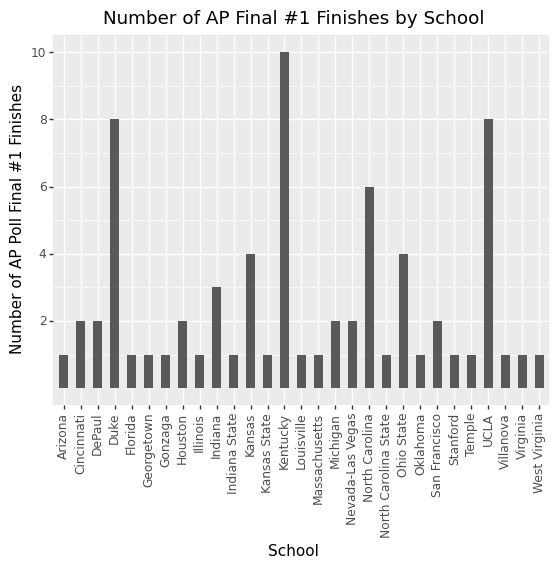

<ggplot: (310890430)>

In [9]:
(ggplot(counts, aes(x= 'team_name', y = 'pts')) +
theme(axis_text_x = element_text(angle=90)) +
xlab('School') + 
ylab('Number of AP Poll Final #1 Finishes') +
ggtitle('Number of AP Final #1 Finishes by School') +
scale_y_continuous(breaks=[2, 4, 6, 8, 10]) +
geom_col(width = 0.5))

Kentucky has acheived this feat a whopping 10 times. Duke and UCLA aren't far behind with 8 times, with North Carolina, Kansas, and Ohio State behind them at 4 times.

In [16]:
# Let's see how some key parts of basketball have changed over time. Let's start with points.
points = top_teams.filter(['team_name', 'pts_per_g', 'opp_pts_per_g'])
points['year'] = points.index.astype(int)
points.reset_index(drop = True, inplace = True)
points['differential'] = points['pts_per_g'] - points['opp_pts_per_g']
points.tail()

,team_name,pts_per_g,opp_pts_per_g,tov,year,differential
66,Kansas,81.3,67.6,478,2016,13.7
67,Villanova,77.2,62.7,402,2017,14.5
68,Virginia,67.1,54.0,290,2018,13.1
69,Duke,82.7,67.8,488,2019,14.9
70,Kansas,74.6,60.7,396,2020,13.9


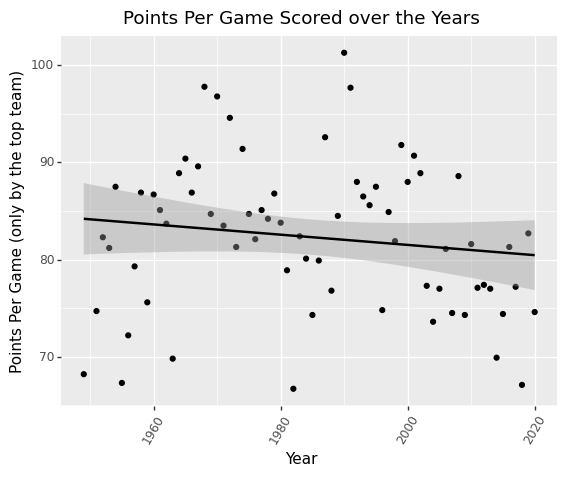

<ggplot: (-9223372036541271541)>

In [17]:
(ggplot(points, aes(x= 'year', y = 'pts_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Points Per Game (only by the top team) ') +
ggtitle('Points Per Game Scored over the Years') +
geom_smooth(method = 'lm'))

# From this plot, you can see that there may be a slight drop in points per game over the years by CBB's best teams. 
# However, by checking the summary of this model, there is no statistically significant difference we can detect. 

In [18]:
import statsmodels.formula.api as sm
ppg_res = sm.ols('year~pts_per_g', data=points).fit()
ppg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.409
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.239
Time:                        15:28:32   Log-Likelihood:                -314.54
No. Observations:                  71   AIC:                             633.1
Df Residuals:                      69   BIC:                             637.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2016.2214     26.426     76.295      0.000    1963.502    2068.941
pts_per_g     -0.3795      0.320     -1.187      0.239      -1.017       0.258
==============================================================================
Omnibus:                       13.220   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.928
Skew:                          -0.185   Prob(JB):                        0.140
Kurtosis:                       1.909   Cond. No.                         893.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

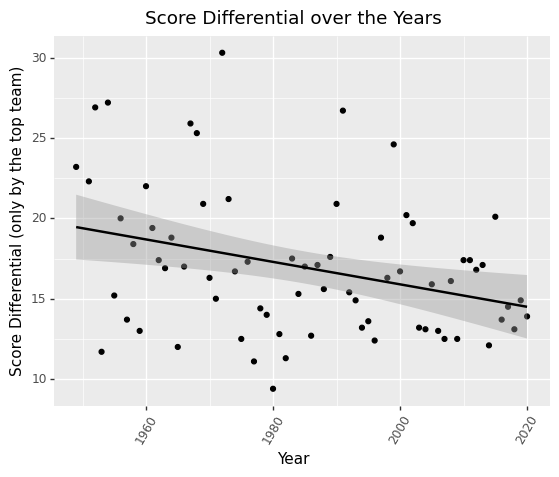

<ggplot: (-9223372036541234695)>

In [19]:
(ggplot(points, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Score Differential (only by the top team) ') +
ggtitle('Score Differential over the Years') +
geom_smooth(method = 'lm'))


# On the other hand, the best teams aren't winning by nearly as much anymore.
# This does have a statistically significant difference, providing a modeling equation of 
# differential = 2010.7460 - 1.5203(year)
# The p-value of .006 shows that this difference is statistically significant. 
# In context, this means that over the years, CBB games have gotten closer over time, and the best teams 
# don't blow out their opponents nearly as often.

In [20]:
diff_res = sm.ols('year~differential', data=points).fit()
diff_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.196
Date:                Wed, 13 May 2020   Prob (F-statistic):            0.00556
Time:                        15:28:33   Log-Likelihood:                -311.27
No. Observations:                  71   AIC:                             626.5
Df Residuals:                      69   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2010.7460      9.296    216.297      0.000    1992.201    2029.292
differential    -1.5203      0.531     -2.863      0.006      -2.580      -0.461
==============================================================================
Omnibus:                       15.692   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.856
Skew:                          -0.011   Prob(JB):                        0.145
Kurtosis:                       1.858   Cond. No.                         69.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

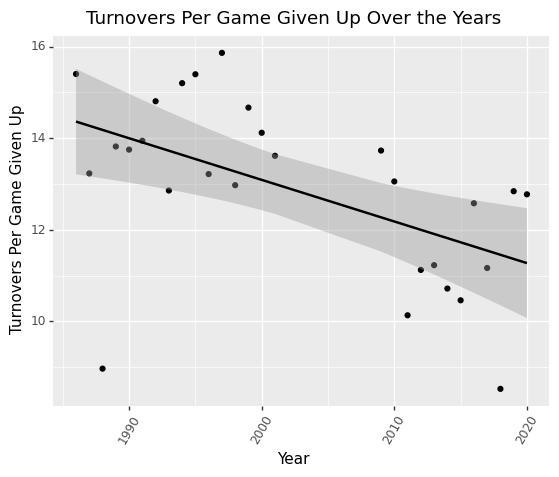

<ggplot: (-9223372036541083497)>

In [45]:
turnovers = top_teams.filter(['g','tov', 'opp_tov'])

# Some teams play more games, so we create a new statistic for both forced and given up turnovers per game played
turnovers['tov_per_g'] = turnovers['tov'] / turnovers['g']
turnovers['opp_tov_per_g'] = turnovers['opp_tov'] / turnovers['g']

# Let's also find the differential in turnovers.
turnovers['differential'] = turnovers['opp_tov_per_g'] - turnovers['tov_per_g']



turnovers['year'] = turnovers.index.astype(int)
turnovers.reset_index(drop = True, inplace = True)
turnovers = turnovers[(turnovers != -1).all(1)]


(ggplot(turnovers, aes(x= 'year', y = 'tov_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Turnovers Per Game Given Up') +
ggtitle('Turnovers Per Game Given Up Over the Years') +
geom_smooth(method = 'lm'))

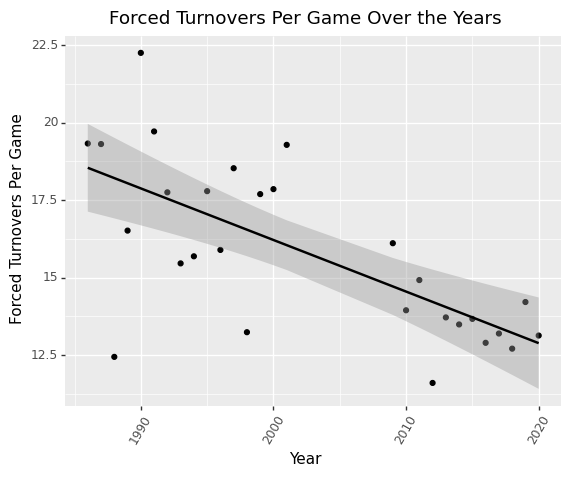

<ggplot: (-9223372036540227689)>

In [46]:
(ggplot(turnovers, aes(x= 'year', y = 'opp_tov_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Forced Turnovers Per Game') +
ggtitle('Forced Turnovers Per Game Over the Years') +
geom_smooth(method = 'lm'))

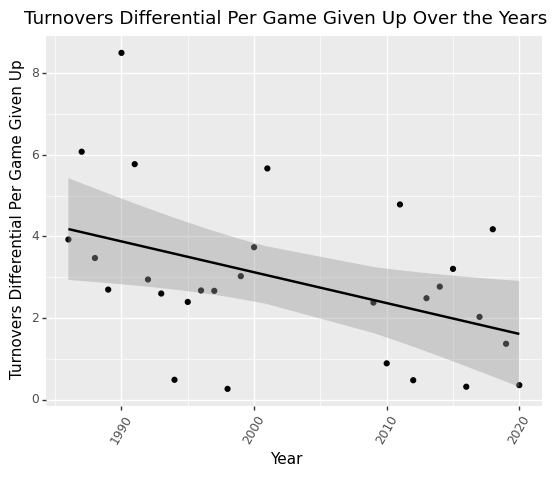

<ggplot: (-9223372036540107509)>

In [48]:
(ggplot(turnovers, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Turnovers Differential Per Game Given Up') +
ggtitle('Turnovers Differential Per Game Given Up Over the Years') +
geom_smooth(method = 'lm'))

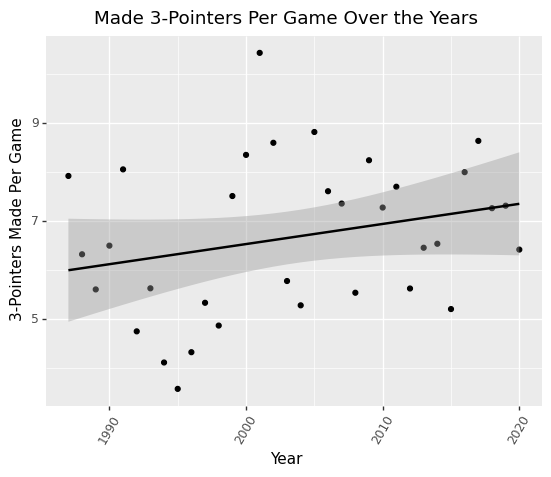

<ggplot: (313537614)>

In [57]:
threes = top_teams.filter(['g','fg3_pct', 'fg3', 'fg3a'])

# Some teams play more games, so we create a new statistic based on games played
threes['fg3_per_g'] = threes['fg3'] / threes['g']
threes['fg3a_per_g'] = threes['fg3a'] / threes['g']

threes['year'] = threes.index.astype(int)
threes.reset_index(drop = True, inplace = True)
threes = threes[(threes != -1).all(1)]


(ggplot(threes, aes(x= 'year', y = 'fg3_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Pointers Made Per Game') +
ggtitle('Made 3-Pointers Per Game Over the Years') +
geom_smooth(method = 'lm'))

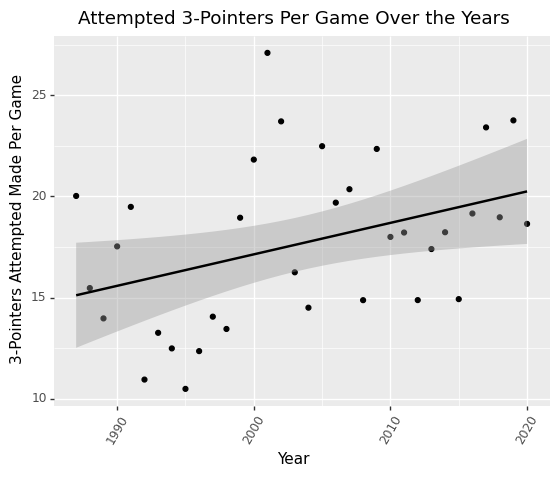

<ggplot: (-9223372036540743785)>

In [58]:
(ggplot(threes, aes(x= 'year', y = 'fg3a_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Pointers Attempted Made Per Game') +
ggtitle('Attempted 3-Pointers Per Game Over the Years') +
geom_smooth(method = 'lm'))

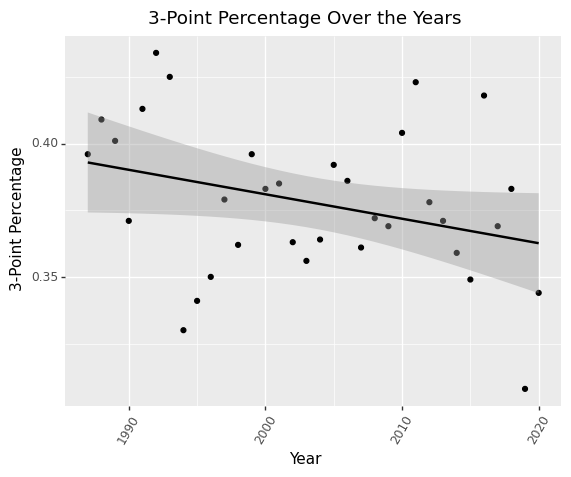

<ggplot: (-9223372036543886420)>

In [62]:
(ggplot(threes, aes(x= 'year', y = 'fg3_pct')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Point Percentage') +
ggtitle('3-Point Percentage Over the Years') +
geom_smooth(method = 'lm'))

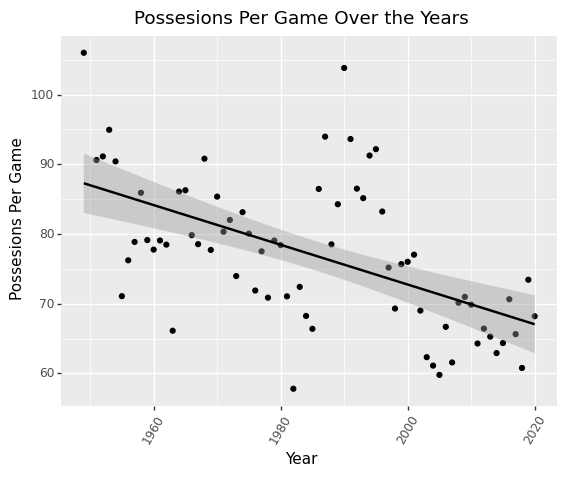

<ggplot: (314521166)>

In [135]:
# Now since it seems teams are over time shooting more threes yet having a worse percentage, let's find the teams that were most efficient in their offenses
# Since, possesions is not avaliable, we have to calculate it using an estimation
# Possessions = 0.5 * (FGA + 0.475 * FTA - ORB + TOV) + 0.5 * (Opp FGA + 0.475 * Opp FTA - Opp ORB + Opp TOV)
# Forumula provided from https://www.sports-reference.com/cbb/about/glossary.html

# We will be calculating possesions per game
efficiency = top_teams.filter(['g', 'pts', 'opp_pts', 'fga', 'fta', 'orb', 'opp_drb', 'fg', 'tov', 'opp_fga', 'opp_FTA', 'opp_orb', 'drb', 'opp_fg', 'opp_tov', 'opp_fta'])

# Every stat converted to its per game equivalency
efficiency = efficiency.div(efficiency['g'], axis=0)

# Add team name
efficiency.insert(0, 'team_name', top_teams['team_name'])


# Estimating possesions
possesions = 0.5 * (efficiency['fga'] + 0.475 * efficiency['fta'] - efficiency['orb'] + efficiency['tov']) + 0.5 * (efficiency['opp_fga'] + 0.475 * efficiency['opp_fta'] - efficiency['opp_orb'] + efficiency['opp_tov'])
efficiency.insert(1, 'possesions', possesions)


efficiency['year'] = efficiency.index.astype(int)

(ggplot(efficiency, aes(x= 'year', y = 'possesions')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Possesions Per Game') +
ggtitle('Possesions Per Game Over the Years') +
geom_smooth(method = 'lm'))



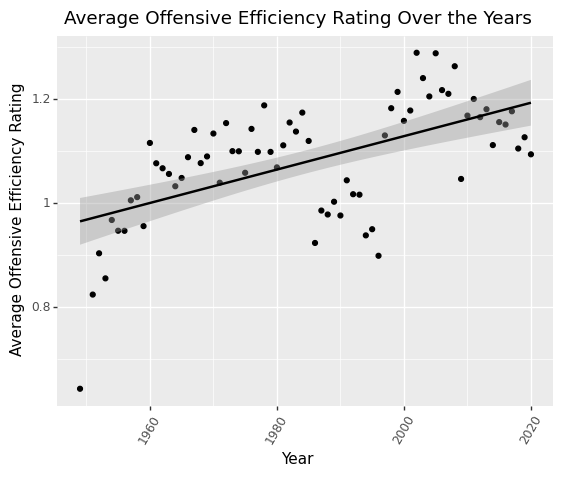

<ggplot: (314033640)>

In [136]:
# Now we can calculate offensive efficiency
# Offensive Efficiency Formula=(Points Scored)/(Possessions)
# Formula from https://www.nbastuffer.com/analytics101/offensive-efficiency/
offensive = efficiency['pts'] / efficiency['possesions']
efficiency.insert(1, 'offensive', offensive)


(ggplot(efficiency, aes(x= 'year', y = 'offensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Offensive Efficiency Rating') +
ggtitle('Average Offensive Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [137]:
efficiency[efficiency['offensive'] == efficiency['offensive'].max()]

,team_name,offensive,possesions,g,pts,opp_pts,fga,fta,orb,opp_drb,fg,tov,opp_fga,opp_orb,drb,opp_fg,opp_tov,opp_fta,year
2002,Duke,1.288379,69.0125,1.0,88.914286,69.171429,63.114286,25.885714,12.228571,-0.028571,31.228571,14.314286,60.542857,-0.028571,25.0,25.485714,-0.028571,-0.028571,2002


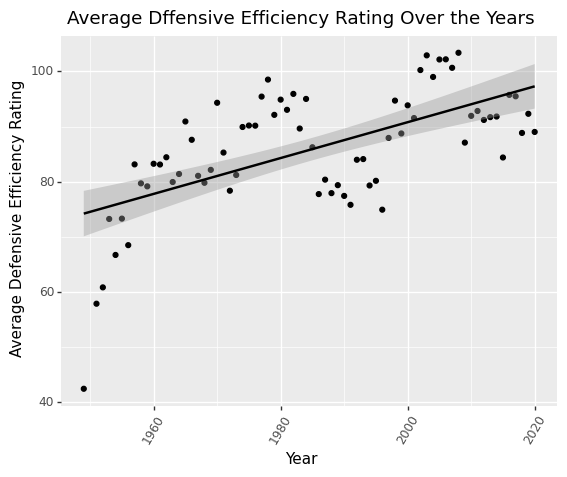

<ggplot: (-9223372036541577486)>

In [138]:
# Now let's calculate defesnive efficiency
#  Defensive Efficiency Fomula=100*(Points Allowed/Possessions)
# Formula from https://www.nbastuffer.com/analytics101/defensive-efficiency/
defensive = 100 * efficiency['opp_pts'] / efficiency['possesions']
efficiency.insert(1, 'defensive', defensive)


(ggplot(efficiency, aes(x= 'year', y = 'defensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Defensive Efficiency Rating') +
ggtitle('Average Dffensive Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [139]:
# The higher the efficiency the more points given up per 100 possesions, so a better team has a low rating
efficiency[efficiency['defensive'] == efficiency['defensive'].min()]

,team_name,defensive,offensive,possesions,g,pts,opp_pts,fga,fta,orb,opp_drb,fg,tov,opp_fga,opp_orb,drb,opp_fg,opp_tov,opp_fta,year
1949,Kentucky,42.453419,0.643738,105.998529,1.0,68.235294,45.0,81.058824,21.411765,-0.029412,-0.029412,26.558824,-0.029412,65.176471,-0.029412,-0.029412,15.823529,45.0,22.235294,1949
